In [1]:
from commpy.channels import awgn
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import seaborn as sns
from pyMRI.utils import RMSE

In [2]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i : met_i+1], t2s[met_i : met_i+1], M_0s[met_i : met_i+1]
spins_phi = np.zeros_like(M_0s)

print("Freqs (rad/s),\t\t T_2s (s),\t M_0s (U.A.),\t phis (rad)")
print(ws, "\t", t2s, "\t", M_0s, "\t", spins_phi)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

Freqs (rad/s),		 T_2s (s),	 M_0s (U.A.),	 phis (rad)
[2411.71251655] 	 [0.0735] 	 [0.4289] 	 [0.]
All frequencies are captured by the sampling rate.


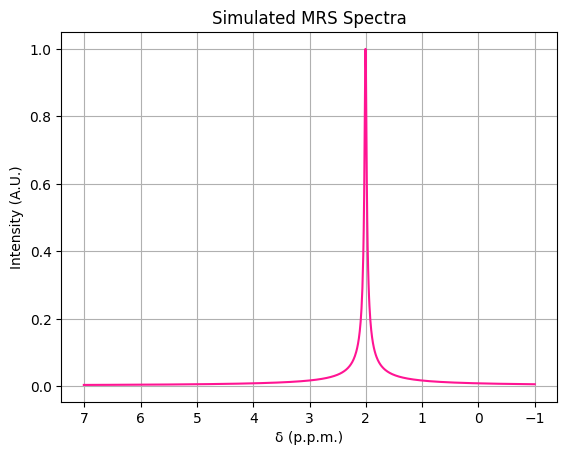

In [3]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
sig_fft = sig_fft/np.max(sig_fft)
sig = np.fft.ifft(np.fft.ifftshift(sig_fft))

pymri.plot_chem_shifts(freqs, sig_fft)

In [4]:
L = 0.4
noise_threshold = 30
L_ = int(L*sig.size)

In [5]:
_, z_, r_ = pymri.filter_sig(sig, L, noise_threshold, return_poles_and_res=True)
original_s0s, original_phis, original_omegas, original_t2s = pymri.calculate_variables_from_z_and_r(z_, r_, dt)
original_t2s = 1/original_t2s

In [6]:
print(original_s0s)

[0.00664024]


## Estatística

Usando os arquivos gerados por one-peak.ipynb

In [7]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i : met_i+1], t2s[met_i : met_i+1], M_0s[met_i : met_i+1]
spins_phi = np.zeros_like(M_0s)

print("Freqs (rad/s),\t\t T_2s (s),\t M_0s (U.A.),\t phis (rad)")
print(ws, "\t", t2s, "\t", M_0s, "\t", spins_phi)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

Freqs (rad/s),		 T_2s (s),	 M_0s (U.A.),	 phis (rad)
[2411.71251655] 	 [0.0735] 	 [0.4289] 	 [0.]
All frequencies are captured by the sampling rate.


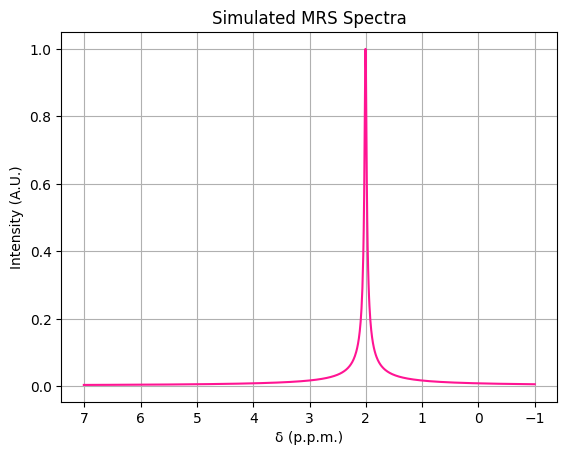

In [8]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop)
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )
sig_fft = sig_fft/np.max(sig_fft)
sig = np.fft.ifft(np.fft.ifftshift(sig_fft))

pymri.plot_chem_shifts(freqs, sig_fft)

In [9]:
rerun = True
ends = ["", "_2"]
filename_end = ends[1]
folder_name = "files/"
subfolder_name = "one-peak/"

In [10]:
s0s = np.load(folder_name + subfolder_name + "s0s__" + filename_end + ".npy")
phis = np.load(folder_name + subfolder_name + "phis__" + filename_end + ".npy")
omegas = np.load(folder_name + subfolder_name + "omegas__" + filename_end + ".npy")
t2s = np.load(folder_name + subfolder_name + "t2s__" + filename_end + ".npy")
snrs = np.load(folder_name + subfolder_name + "snrs" + filename_end + ".npy")
scales = np.load(folder_name + subfolder_name + "scales" + filename_end + ".npy")

In [11]:
print(s0s.shape)

(50, 12, 819)


In [12]:
shape = s0s.shape

filtered_s0 = np.zeros(shape)
filtered_phi = np.zeros(shape)
filtered_omega = np.zeros(shape)
filtered_t2 = np.zeros(shape)

In [13]:
i_avg = 0
i_scale = 0

# Construção dos filtros
omega_filter = pymri.filter_omegas(omegas[i_avg, i_scale, :], dt)
t2_filter = pymri.filter_t2(t2s[i_avg, i_scale, :])

filter = pymri.compose_filters((omega_filter, t2_filter))

# Filtragem
filtered_s0 =  s0s[i_avg, i_scale, :][filter]
filtered_phi = phis[i_avg, i_scale, :][filter]
filtered_omega = omegas[i_avg, i_scale, :][filter]
filtered_t2 = t2s[i_avg, i_scale, :][filter]


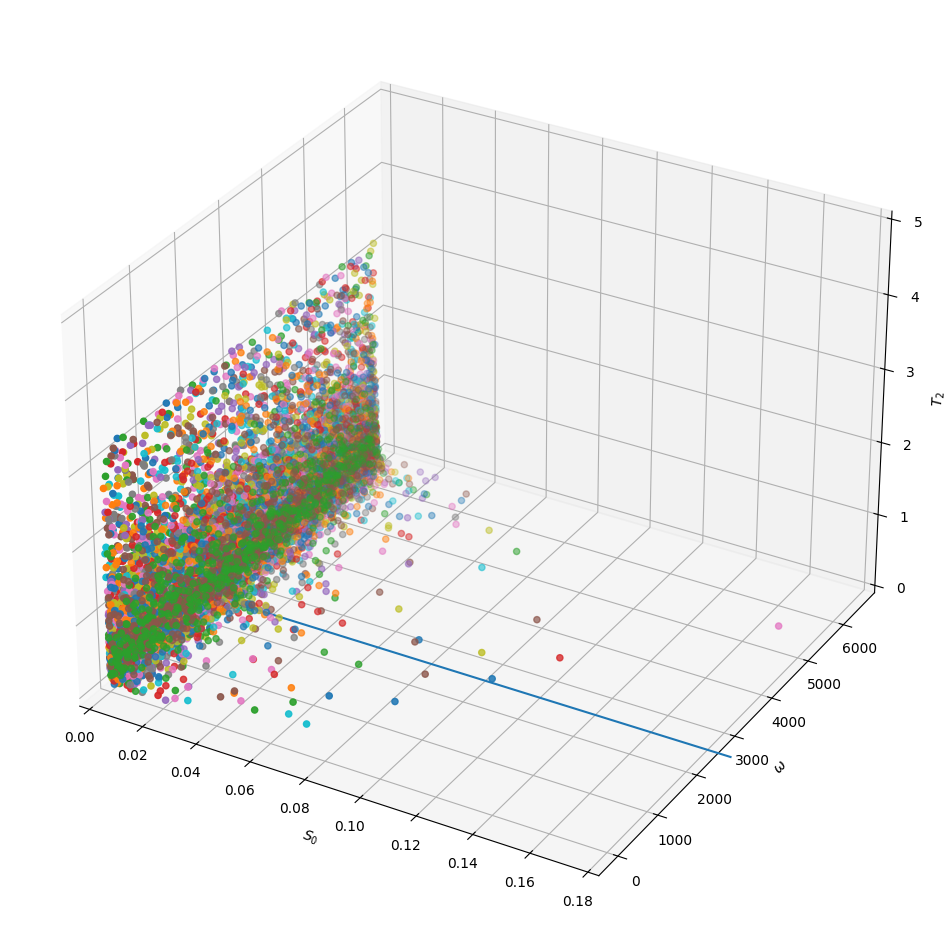

In [17]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

x = np.arange(0.0, 0.2, 0.01)


for i in range(s0s.shape[0]):
    omega_filter = pymri.filter_omegas(omegas[i, i_scale, :], dt)
    t2_filter = pymri.filter_t2(t2s[i, i_scale, :])

    filter = pymri.compose_filters((omega_filter, t2_filter))

    # Filtragem
    filtered_s0 =  s0s[i, i_scale, :][filter]
    filtered_phi = phis[i, i_scale, :][filter]
    filtered_omega = omegas[i, i_scale, :][filter]
    filtered_t2 = t2s[i, i_scale, :][filter]
    # ax.scatter(filtered_omega, filtered_t2, filtered_s0)
    ax.scatter(filtered_s0, filtered_omega, filtered_t2) #(w, T2, s0)

ax.plot(x, np.full_like(x, original_omegas[0]), np.zeros_like(x))
    

ax.set_zlim(0.0, 5.0)
ax.set_xlim(0.0, 0.180)

ax.set_xlabel(r"$S_0$")
ax.set_ylabel(r"$\omega$")
ax.set_zlabel(r"$T_2$")

plt.show()

## Segundo cenário

### Sem ruído

In [2]:
M0s_2 = np.array([10.0, 15.0, 20.0, 25.0])
omegas_2 = pymri.hz_to_rad(np.array([25.0, 75.0, 125.0, 175.0])) # hz
t2s_2 = np.array([0.25, 0.5, 0.75, 1.0])
# phis__ = np.array([np.pi/3, np.pi/4, np.pi/5, np.pi/6])
phis_2 = np.array([0.0, 0.0, 0.0, 0.0])

n_points = 2048
t0_2, tn_2, dt_2, B0 = pymri.setup_sim_t(0.0, 4.096, n_points, 3.0)

print(omegas_2)
print(t0_2, tn_2, dt_2)



[ 157.07963268  471.23889804  785.3981634  1099.55742876]
0.0 4.096 0.002


(0.0, 200.0)

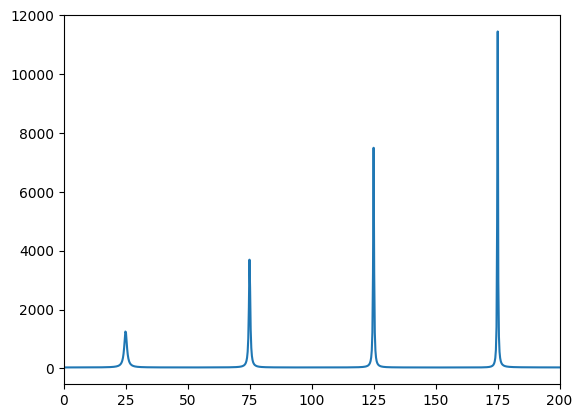

In [5]:
pop_2 = pymri.population(omegas_2, t2s_2, M0s_2, phis_2)

sig_2, t = pymri.population_transverse_decay( t0_2, tn_2, dt_2, pop_2)
freqs_2, sig_fft_2 = pymri.fourier_spectrum( sig_2, dt_2, B0 )
freqs_2 = pymri.f_from_chem_shift(freqs_2, B0)
sig_2 = np.fft.ifft(np.fft.ifftshift(sig_fft_2))

plt.plot(freqs_2, sig_fft_2.real)
plt.xlim(0.0, 200.0)

In [6]:
_, z_2, r_2 = pymri.filter_sig(sig_2, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
reconstructed_s0s, reconstructed_phis, reconstructed_omegas, reconstructed_t2s = pymri.calculate_variables_from_z_and_r(z_2, r_2, dt_2)
reconstructed_t2s = 1/reconstructed_t2s

NameError: name 'L' is not defined

[-1.20000000e-01 -1.10000000e-01 -1.00000000e-01 -9.00000000e-02
 -8.00000000e-02 -7.00000000e-02 -6.00000000e-02 -5.00000000e-02
 -4.00000000e-02 -3.00000000e-02 -2.00000000e-02 -1.00000000e-02
 -5.55111512e-17  1.00000000e-02  2.00000000e-02  3.00000000e-02
  4.00000000e-02  5.00000000e-02  6.00000000e-02  7.00000000e-02
  8.00000000e-02  9.00000000e-02  1.00000000e-01  1.10000000e-01
  1.20000000e-01  1.30000000e-01  1.40000000e-01  1.50000000e-01
  1.60000000e-01  1.70000000e-01  1.80000000e-01  1.90000000e-01
  2.00000000e-01  2.10000000e-01  2.20000000e-01  2.30000000e-01
  2.40000000e-01]


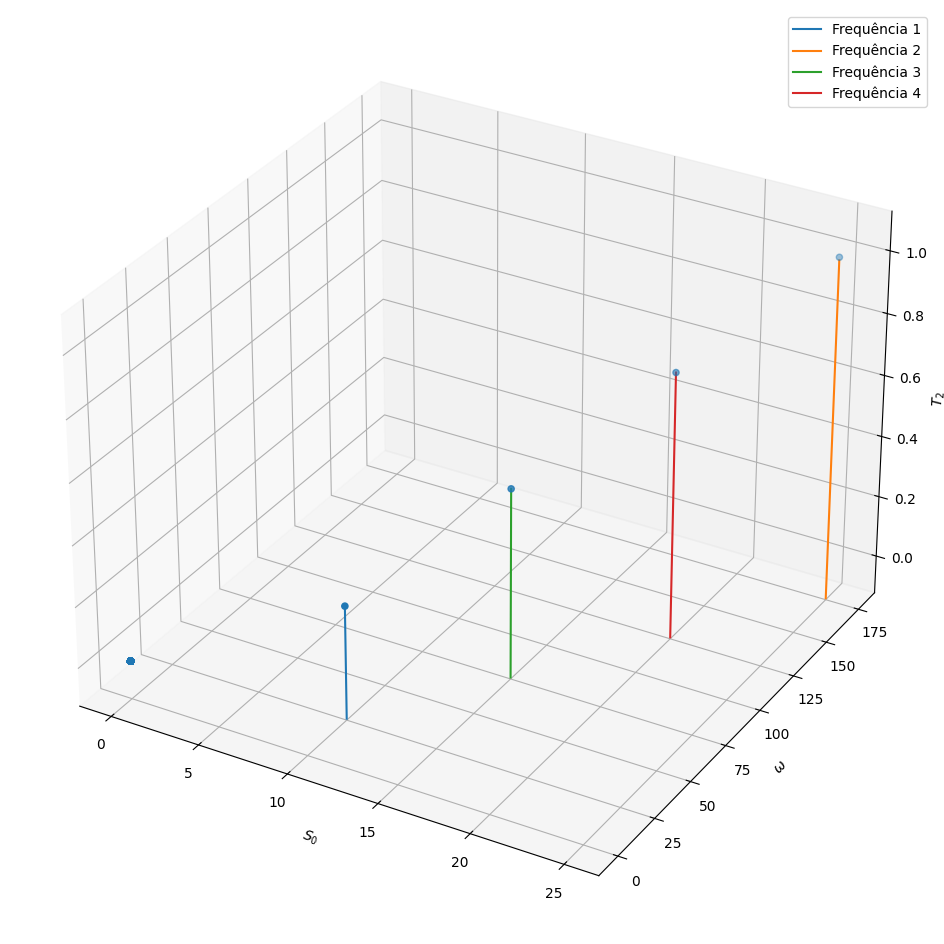

In [78]:
fig_2 = plt.figure(figsize=(12, 12))
ax_2 = fig_2.add_subplot(projection='3d')

z1 = np.arange(-0.12, reconstructed_t2s[reconstructed_t2s != 0.0][0], 0.01)
z2 = np.arange(-0.12, reconstructed_t2s[reconstructed_t2s != 0.0][1], 0.01)
z3 = np.arange(-0.12, reconstructed_t2s[reconstructed_t2s != 0.0][2], 0.01)
z4 = np.arange(-0.12, reconstructed_t2s[reconstructed_t2s != 0.0][3], 0.01)

y1 = np.full_like(z1, pymri.rad_to_hz(reconstructed_omegas[reconstructed_omegas != 0.0][0]))
y2 = np.full_like(z2, pymri.rad_to_hz(reconstructed_omegas[reconstructed_omegas != 0.0][1]))
y3 = np.full_like(z3, pymri.rad_to_hz(reconstructed_omegas[reconstructed_omegas != 0.0][2]))
y4 = np.full_like(z4, pymri.rad_to_hz(reconstructed_omegas[reconstructed_omegas != 0.0][3]))

x1 = np.full_like(z1, reconstructed_s0s[reconstructed_s0s != 0.0][0])
x2 = np.full_like(z2, reconstructed_s0s[reconstructed_s0s != 0.0][1])
x3 = np.full_like(z3, reconstructed_s0s[reconstructed_s0s != 0.0][2])
x4 = np.full_like(z4, reconstructed_s0s[reconstructed_s0s != 0.0][3])

print(z1)

# Filtragem
filtered_s0_2 =  reconstructed_s0s
filtered_phi_2 = reconstructed_phis
filtered_omega_2 = reconstructed_omegas
filtered_t2_2 = reconstructed_t2s
ax_2.scatter(reconstructed_s0s, pymri.rad_to_hz(reconstructed_omegas), reconstructed_t2s) #(w, T2, s0)
ax_2.plot(x1, y1, z1, label = "Frequência 1")
ax_2.plot(x2, y2, z2, label = "Frequência 2")
ax_2.plot(x3, y3, z3, label = "Frequência 3")
ax_2.plot(x4, y4, z4, label = "Frequência 4")

ax_2.set_zlim(-0.1, 1.1)


ax_2.set_xlabel(r"$S_0$")
ax_2.set_ylabel(r"$\omega$")
ax_2.set_zlabel(r"$T_2$")

plt.legend()

plt.show()

### Adição de ruído

In [92]:
rerun = True
ends = ["", "_2"]
filename_end = ends[0]
folder_name = "files/"
subfolder_name = "clusters/"

In [93]:
scales = np.array([0.0, 0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.001, 0.00075, 0.0005, 0.00025, 0.0001])
windows = np.arange(5.0, 105.0, 5.0)
loc = 0.0

print(scales.size, windows.size)
n_avgs = 10

13 20


In [ ]:
pymri.plot_chem_shifts(freqs_2, sig_fft_2)

In [94]:
shape = (n_avgs, scales.size, L_)
s0s__, phis__, omegas__, t2s__ = np.zeros(shape), np.zeros(shape), np.zeros(shape), np.zeros(shape)
snrs = np.zeros((n_avgs, scales.size))

In [95]:
if rerun == True:
    for i in range(n_avgs):
        for j in range(scales.size):
                noise = np.random.normal(loc, scales[j], 2048) + 1j*np.random.normal(loc, scales[j], 2048)
                c_sig_fft = sig_fft + noise
                snrs[i, j] = pymri.snr(c_sig_fft)

                c_sig = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

                _, z, r = pymri.filter_sig(c_sig, L, noise_threshold, rcond=1e-7, return_poles_and_res=True, return_full_arrays=True)
                s0s__[i, j, :], phis__[i, j, :], omegas__[i, j, :], t2s__[i, j, :] = pymri.calculate_variables_from_z_and_r(z, r, dt_2)
                t2s__[i, j, :] = 1/t2s__[i, j, :]
                        

In [102]:
if rerun == True:
    np.save(folder_name + subfolder_name + "s0s__" + filename_end, s0s__)
    np.save(folder_name + subfolder_name + "phis__" + filename_end, phis__)
    np.save(folder_name + subfolder_name + "omegas__" + filename_end, omegas__)
    np.save(folder_name + subfolder_name + "t2s__" + filename_end, t2s__)
    np.save(folder_name + subfolder_name + "snrs" + filename_end, snrs)
    np.save(folder_name + subfolder_name + "scales" + filename_end, scales)

In [ ]:
if rerun == False:
    s0s__ = np.load(folder_name + subfolder_name + "s0s__" + filename_end + ".npy")
    phis__ = np.load(folder_name + subfolder_name + "phis__" + filename_end + ".npy")
    omegas__ = np.load(folder_name + subfolder_name + "omegas__" + filename_end + ".npy")
    t2s__ = np.load(folder_name + subfolder_name + "t2s__" + filename_end + ".npy")
    snrs = np.load(folder_name + subfolder_name + "snrs" + filename_end + ".npy")
    scales = np.load(folder_name + subfolder_name + "scales" + filename_end + ".npy")

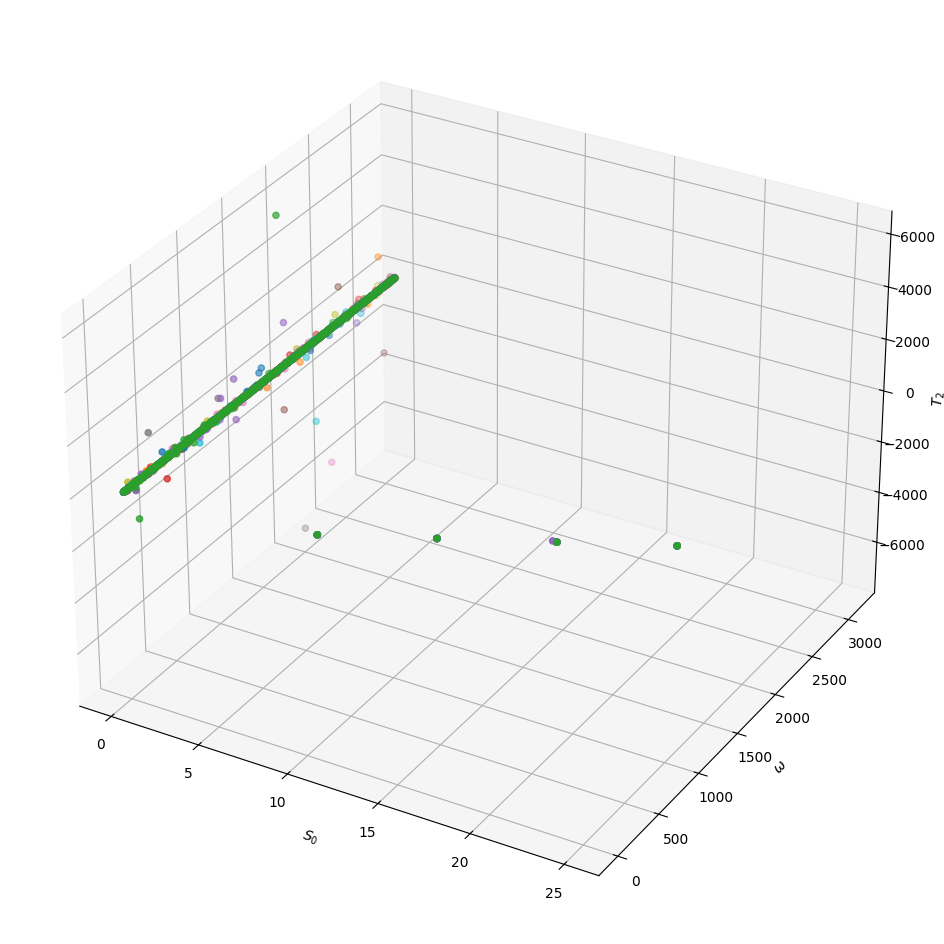

In [108]:
fig_3 = plt.figure(figsize=(12, 12))
ax_3 = fig_3.add_subplot(projection='3d')

i_scale = 1


for i in range(s0s__.shape[0]):
    # if(i != 0): # Excluindo o primeiro caso que não tem ruído e irá trazer problemas para a filtragem de t2
    #     omega_filter = pymri.filter_omegas(omegas__[i, i_scale, :], dt_2)
    #     print(t2s__)
    #     t2_filter = pymri.filter_t2(t2s__[i, i_scale, :])

    #     filter = pymri.compose_filters((omega_filter, t2_filter))
    # else: 
    #     filter = np.full_like(L_, True, dtype = bool)

    # Filtragem
    filtered_s0 =  s0s__[i, i_scale, :]
    filtered_phi = phis__[i, i_scale, :]
    filtered_omega = omegas__[i, i_scale, :]
    filtered_t2 = t2s__[i, i_scale, :]
    # ax.scatter(filtered_omega, filtered_t2, filtered_s0)
    ax_3.scatter(filtered_s0, filtered_omega, filtered_t2) #(w, T2, s0)

# ax_3.plot(x1, y1, z1, label = "Frequência 1")
# ax_3.plot(x2, y2, z2, label = "Frequência 2")
# ax_3.plot(x3, y3, z3, label = "Frequência 3")
# ax_3.plot(x4, y4, z4, label = "Frequência 4")
    

# ax_3.set_zlim(0.0, 5.0)
# ax_3.set_xlim(0.0, 0.180)

ax_3.set_xlabel(r"$S_0$")
ax_3.set_ylabel(r"$\omega$")
ax_3.set_zlabel(r"$T_2$")

plt.show()